In [1]:
# %%
# 程式碼區塊 1：載入套件與資料

# Import basic data processing and visualization libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import scikit-learn modules
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    roc_auc_score, f1_score, recall_score, precision_score, 
    confusion_matrix, classification_report, 
    RocCurveDisplay, PrecisionRecallDisplay
)
from sklearn.pipeline import make_pipeline

# Import model libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# 設定全局字體
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.unicode_minus'] = False

# 讀取資料
df = pd.read_csv("VerbalFluencyTest_rawdata.csv")
df.head()


,NUMBER,Age,Gender,Analysis Result,Verbal Fluency,Lexical Richness,Speech Rate,Accuracy,Voice Fluency
0,1,63,2,Normal,0.895205,0.684282,0.854517,1.000000,0.940569
1,2,67,2,Dementia,0.563597,0.267195,0.853779,0.653680,0.442837
2,3,69,1,Dementia,0.227932,0.136541,0.317103,0.317103,0.616538
3,4,58,2,Normal,1.000000,0.683591,0.939348,1.000000,0.895420
4,5,72,2,Dementia,0.606681,0.201904,0.407563,0.541407,0.436888


In [9]:
# %%
# 程式碼區塊 2：資料前處理（篩選與標準化）

# 類別編碼與特徵選取（保持不變）
df_model = df[df["Analysis Result"] != "Inconclusive"].copy().dropna()
label_encoder = LabelEncoder()
df_model["label"] = label_encoder.fit_transform(df_model["Analysis Result"])

features = ["Verbal Fluency", "Lexical Richness", "Speech Rate", "Accuracy", "Voice Fluency"]
X = df_model[features]
y = df_model["label"]

# 先分割資料再標準化
X_train, X_test, y_train, y_test = train_test_split(
    X, y,  # 這裡使用原始未標準化數據
    test_size=0.2, 
    random_state=42,
    stratify=y
)


# 確認形狀與比例
print(f"訓練集形狀: {X_train.shape} ({len(X_train)/len(X):.2%})")
print(f"測試集形狀: {X_test.shape} ({len(X_test)/len(X):.2%})")

訓練集形狀: (768, 5) (80.00%)
測試集形狀: (192, 5) (20.00%)


In [10]:
print("訓練集類別比例:", {0: sum(y_train==0), 1: sum(y_train==1)})
print("測試集類別比例:", {0: sum(y_test==0), 1: sum(y_test==1)})

訓練集類別比例: {0: 110, 1: 658}
測試集類別比例: {0: 28, 1: 164}


In [11]:
# %%
# 程式碼區塊 3：模型訓練與評估
# 設定評估指標
scoring = { 
    'roc_auc': 'roc_auc',
    'f1': 'f1',
    'recall': 'recall',
    'precision': 'precision'
}

# 設定交叉驗證
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# 修改後的程式碼區塊3：比較內建平衡機制
models = [
    {
        'name': 'LogisticRegression_Balanced',
        'model': make_pipeline(
            StandardScaler(),  # 在管道中標準化
            LogisticRegression(
                penalty='l2',
                C=1.0,
                class_weight='balanced',  # 啟用內建平衡
                max_iter=1000,
                random_state=42
            )
        )
    },
    {
        'name': 'RandomForest_Balanced',
        'model': make_pipeline(
            StandardScaler(),  # 在管道中標準化
            RandomForestClassifier(
                max_depth=5,
                min_samples_split=10,
                class_weight='balanced_subsample',
                max_features='sqrt',
                n_estimators=100,
                random_state=42
            )
        )
    },
    {
        'name': 'XGBoost_Weighted',
        'model': make_pipeline(
            StandardScaler(),  # 在管道中標準化
            XGBClassifier(
                scale_pos_weight=len(y_train[y_train==1])/len(y_train[y_train==0]),  # 575/97 ≈ 5.93
                eval_metric='logloss',
                use_label_encoder=False
            )
        )
    }
]

# 重新執行比較
results = []
for model_info in models:
    scores = cross_validate(
        estimator=model_info['model'],
        X=X_train,
        y=y_train,
        cv=cv,
        scoring=scoring,
        n_jobs=-1,
        return_train_score=False
    )
    
    results.append({
        'model': model_info['name'],
        'auc_mean': np.mean(scores['test_roc_auc']),
        'auc_std': np.std(scores['test_roc_auc']),
        'f1_mean': np.mean(scores['test_f1']),
        'recall_mean': np.mean(scores['test_recall']),
        'precision_mean': np.mean(scores['test_precision'])
    })

# 顯示結果
results_df = pd.DataFrame(results).sort_values(by='auc_mean', ascending=False)
print(results_df[['model', 'auc_mean', 'auc_std', 'f1_mean', 'recall_mean', 'precision_mean']])

                         model  auc_mean   auc_std   f1_mean  recall_mean  \
1        RandomForest_Balanced  0.991687  0.010847  0.983906     0.980210   
2             XGBoost_Weighted  0.991545  0.012424  0.985620     0.989324   
0  LogisticRegression_Balanced  0.991007  0.011239  0.974215     0.957413   

   precision_mean  
1        0.987861  
2        0.982057  
0        0.992319  


In [12]:
# %%
# 程式碼區塊4：最佳模型訓練與評估
# 初始化最佳模型（根據交叉驗證結果選擇RandomForest_Balanced）
best_model = make_pipeline(
    StandardScaler(),  # 在管道中標準化
    RandomForestClassifier(
        max_depth=5,
        min_samples_split=10,
        class_weight='balanced_subsample',
        max_features='sqrt',
        n_estimators=100,
        random_state=42
    )
)

# 完整訓練流程
best_model.fit(X_train, y_train)  # 使用全部訓練數據

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        max_depth=5, min_samples_split=10,
                                        random_state=42))])

In [13]:
# 檢查 Pipeline 標準化是否正常運作
scaler = best_model.named_steps['standardscaler']
print("訓練集標準化均值：", scaler.mean_)  # 應等於 X_train 的原始均值
print("測試集樣本標準化後示例：", scaler.transform(X_test[:1]))

訓練集標準化均值： [0.69063243 0.61614101 0.73733923 0.78542596 0.82029447]
測試集樣本標準化後示例： [[0.94557733 0.95049351 0.87688945 0.73712073 0.22260043]]



=== 測試集最終報告 ===
              precision    recall  f1-score   support

      Normal      0.903     1.000     0.949        28
    Dementia      1.000     0.982     0.991       164

    accuracy                          0.984       192
   macro avg      0.952     0.991     0.970       192
weighted avg      0.986     0.984     0.985       192



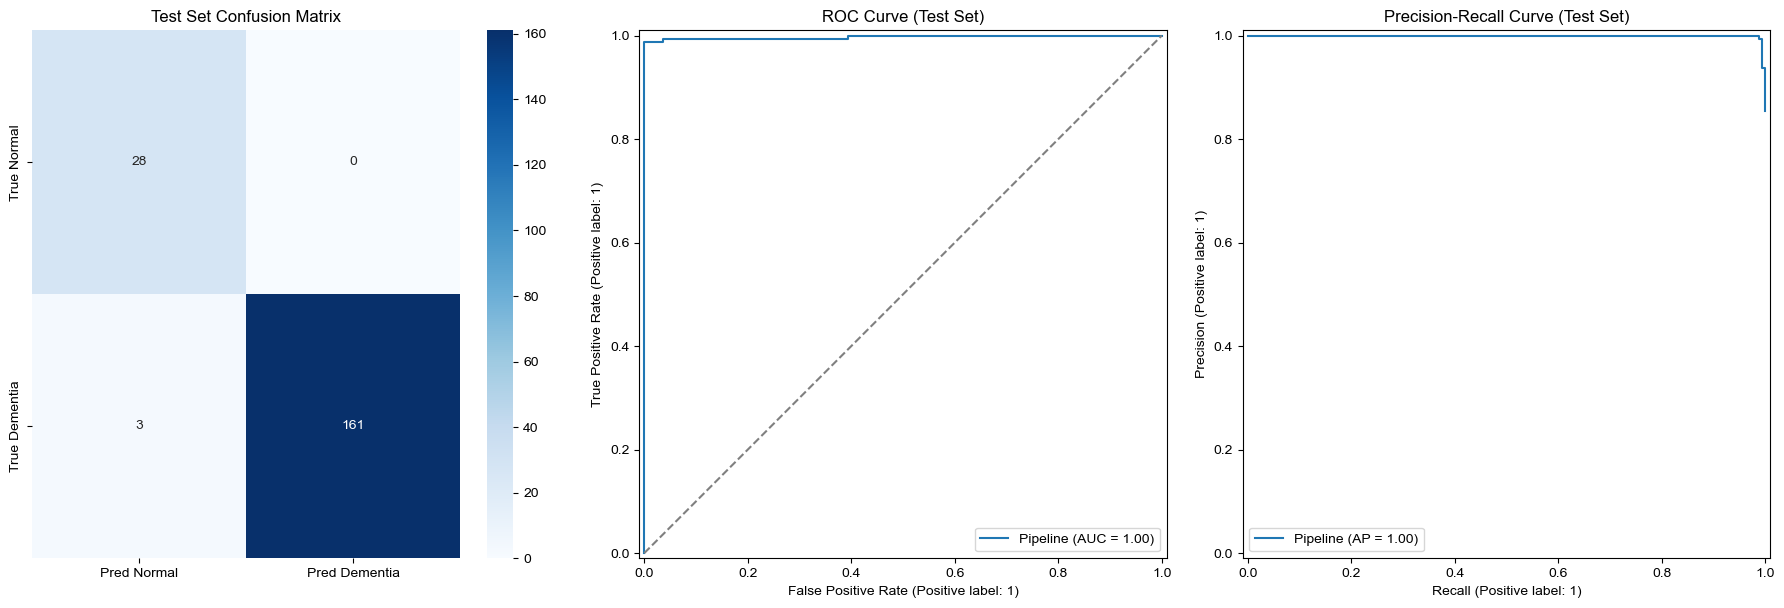

C:\Users\speech\AppData\Local\Temp\ipykernel_21464\320102326.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='viridis')


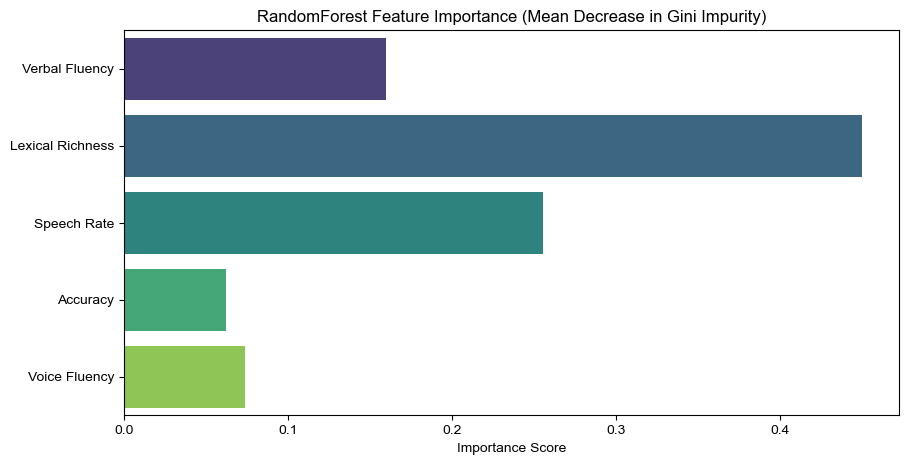

In [ ]:
# %%
# 程式碼區塊5：驗證集評估與測試集最終報告
# 測試集評估
print("\n=== 測試集最終報告 ===")
y_test_pred = best_model.predict(X_test)
y_test_proba = best_model.predict_proba(X_test)[:,1]

# 完整分類報告
print(classification_report(y_test, y_test_pred, 
                           target_names=['Normal', 'Dementia'],
                           digits=3))

# 可視化分析
# 創建一個1x3的子圖佈局
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 混淆矩陣（測試集）
sns.heatmap(confusion_matrix(y_test, y_test_pred), 
            annot=True, fmt='d', ax=axes[0],
            xticklabels=['Pred Normal', 'Pred Dementia'],
            yticklabels=['True Normal', 'True Dementia'], cmap='Blues')
axes[0].set_title("Test Set Confusion Matrix")

# ROC曲線
RocCurveDisplay.from_estimator(best_model, X_test, y_test, ax=axes[1])
axes[1].plot([0, 1], [0, 1], linestyle='--', color='gray')
axes[1].set_title("ROC Curve (Test Set)")

# PR曲線
PrecisionRecallDisplay.from_estimator(best_model, X_test, y_test, ax=axes[2])
axes[2].set_title("Precision-Recall Curve (Test Set)")

plt.tight_layout()
plt.show()

# 特徵重要性分析（隨機森林專用）
rf_step = best_model.named_steps['randomforestclassifier']
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': rf_step.feature_importances_
})

plt.figure(figsize=(10,5))
sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='viridis')
plt.title("RandomForest Feature Importance (Mean Decrease in Gini Impurity)")
plt.xlabel("Importance Score")
plt.ylabel("")
plt.show()

In [21]:
# 檢查特徵與標籤的關聯性
from scipy.stats import pointbiserialr

correlations = []
for feature in features:
    corr, _ = pointbiserialr(df_model[feature], df_model["label"])
    correlations.append(abs(corr))

pd.DataFrame({'Feature': features, '|Correlation|': correlations}) \
  .sort_values('|Correlation|', ascending=False)

,Feature,|Correlation|
1,Lexical Richness,0.751787
2,Speech Rate,0.678575
0,Verbal Fluency,0.672804
3,Accuracy,0.641676
4,Voice Fluency,0.567655
